In [1]:
# See how much memory is used by OS initially.
# Then substract this value from later mem used, to obtain mem used by scripts.
import psutil
GB_UNIT = 1000*1024**2
MB_UNIT = GB_UNIT/1e3
OS_MEM = psutil.virtual_memory().used
print(OS_MEM/GB_UNIT)


from shared.preface import *
import shared.functions as fct


# Initialize parameters and files.
PRE = PRE(
    sim='L025N752', 
    z0_snap=36, z4_snap=13, DM_lim=20000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=10, thetas=10, vels=100,
    pre_CPUs=128, sim_CPUs=128, mem_lim_GB=224
)


TEMP_DIR = f'X_tests'

mass_gauge = 12.0
mass_range = 0.6
size = 1

hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
fct.halo_batch_indices(
    PRE.Z0_STR, mass_gauge, mass_range, 'halos', size, 
    hname, PRE.SIM_DIR, TEMP_DIR
)
halo_batch_IDs = np.load(f'{TEMP_DIR}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{TEMP_DIR}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('********Number density band********')
print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)
print('***********************************')

31.098921875
********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 10, THETAs=10, Vs=100
Total neutrinos: 10000
# Simulation parameters:
Simulation box: L025N752
Snapshot from 0036 (z=0) to 0013 (z=4)
Pre/Sim CPUs 128/128
DM limit for cells: 20000
# File management:
Box files directory: 
 /projects/0/einf180/Tango_sims/L025N752/DMONLY/SigmaConstant00
Output directory: 
 /gpfs/home4/zimmer/neutrino_clustering_V2/L025N752/DMONLY/SigmaConstant00
**********************************************************
********Number density band********
Halo batch params (Rvir,Mvir,cNFW):
[[253.5523526   12.24058042   6.9286026 ]]
***********************************


In [2]:
# =============================================== #
# Run precalculations for selected halo in batch. #
# =============================================== #

halo_j = 0
halo_ID = halo_batch_IDs[halo_j]

halo_rvir = halo_batch_params[halo_j, 0]
halo_Mvir = halo_batch_params[halo_j, 1]
halo_cNFW = halo_batch_params[halo_j, 2]

# Generate progenitor index array for current halo.
splits = re.split('/', SIM_TYPE)
MTname = f'{PRE.SIM}_{splits[0]}_{splits[1]}'
proj_IDs = fct.read_MergerTree(PRE.OUT_DIR, MTname, halo_ID)


j = 0
snap = PRE.NUMS_SNAPS[::-1][0]
proj_ID = proj_IDs[0]

proj_ID = int(proj_ID)

# Output halo progress.
print(f'halo {halo_j+1}/{halo_num} ; snapshot {snap}')

# --------------------------- #
# Read and load DM positions. #
# --------------------------- #

IDname = f'origID{halo_ID}_snap_{snap}'
fct.read_DM_halo_index(
    snap, proj_ID, IDname, PRE.SIM_DIR, TEMP_DIR
)
DM_raw = np.load(f'{TEMP_DIR}/DM_pos_{IDname}.npy')
DM_particles = len(DM_raw)


# ---------------------- #
# Cell division process. #
# ---------------------- #

# Initialize grid.
snap_GRID_L = (int(np.abs(DM_raw).max()) + 1)*kpc
raw_grid = fct.grid_3D(snap_GRID_L, snap_GRID_L)
init_grid = np.expand_dims(raw_grid, axis=1)

# Prepare arrays for cell division.
DM_raw *= kpc
DM_pos = np.expand_dims(DM_raw, axis=0)
DM_pos_for_cell_division = np.repeat(DM_pos, len(init_grid), axis=0)
del DM_raw

# Cell division.
cell_division_count = fct.cell_division(
    init_grid, DM_pos_for_cell_division, snap_GRID_L, PRE.DM_LIM, None, TEMP_DIR, IDname
)
del DM_pos_for_cell_division


# Load files from cell division.
fin_grid = np.load(f'{TEMP_DIR}/fin_grid_{IDname}.npy')
DM_count = np.load(f'{TEMP_DIR}/DM_count_{IDname}.npy')
cell_com = np.load(f'{TEMP_DIR}/cell_com_{IDname}.npy')
cell_gen = np.load(f'{TEMP_DIR}/cell_gen_{IDname}.npy')
print(fin_grid.shape)

# --------------------------------------------- #
# Calculate gravity grid (in batches of cells). #
# --------------------------------------------- #
cell_coords = np.squeeze(fin_grid, axis=1)
cells = len(cell_coords)

halo 1/1 ; snapshot 0036
(176, 1, 3)


Following cell shows the reason, why beyond the virial radius, the ratio of the cell gravity and NFW has a different value than one. NFW uses the virial mass, whereas my implementation uses the total mass of all DM particles of the halo.

In [ ]:
mass1 = 10**halo_Mvir
mass2 = PRE.DM_SIM_MASS*DM_particles/Msun
print(mass2/mass1)
# The last ratio is exactly what we can see (outside the virial radius) with 
# the gravity_comparison_NFW function below.

## Short-range gravity.

In [16]:
def chunksize_short_range(cells, DM_tot, max_DM_lim, core_mem_MB):

    # note: mem_MB specific to peak memory usage in cell_gravity_short_range.
    # -> Peak memory after calculation of ind_2D,ind_3D,etc. sorting arrays.

    elem = 8                               # 8 bytes for standard np.float64
    mem_type0 = cells*3 * elem             # for list to ndarray of cell_coords
    mem_type1 = cells*DM_tot * elem        # for ind_2D
    mem_type2 = cells*DM_tot*3 * elem      # for DM_pos_sync, ind_3D, DM_sort
    mem_type3 = cells*max_DM_lim*3 * elem  # for DM_in

    mem_MB = (mem_type0+mem_type1+(3*mem_type2)+mem_type3)/1.e6

    batches = 1
    while mem_MB >= 0.95*core_mem_MB:
        mem_MB *= batches
        batches += 1
        mem_MB /= batches

    chunksize = math.ceil(cells/batches)

    return chunksize


def batch_generators_short_range(cell_coords, cell_gen, chunksize):

    cells = len(cell_coords)

    batches = math.ceil(cells/chunksize)
    batch_arr = np.arange(batches)

    cell_chunks = chunks(chunksize, cell_coords)
    cgen_chunks = chunks(chunksize, cell_gen)
    
    return batch_arr, cell_chunks, cgen_chunks


def cell_gravity_short_range(
    cell_coords_in, cell_gen, init_GRID_S,
    DM_pos, DM_lim, DM_sim_mass, smooth_l,
    out_dir, b_id, max_b_len
):

    cell_coords = np.expand_dims(np.array(cell_coords_in), axis=1)
    cell_gen = np.array(cell_gen)

    # Center all DM positions w.r.t. cell center.
    # DM_pos already in shape = (1, DM_particles, 3)
    DM_pos_sync = np.repeat(DM_pos, len(cell_coords), axis=0)
    DM_pos_sync -= cell_coords

    # Cell lengths to limit DM particles. Limit for the largest cell is 
    # GRID_S/2, not just GRID_S, therefore the cell_gen+1 !
    cell_len = np.expand_dims(init_GRID_S/(2**(cell_gen+1)), axis=1)

    # Select DM particles inside each cell based on cube length generation.
    DM_in_cell_IDs = np.asarray(
        (np.abs(DM_pos_sync[:,:,0]) < cell_len) & 
        (np.abs(DM_pos_sync[:,:,1]) < cell_len) & 
        (np.abs(DM_pos_sync[:,:,2]) < cell_len)
    )
    #? < results in 1 missing DM particle. Using <= though overcounts
    #? is there a way to get every DM particle by adjusting rtol and atol ?
    # -> not pressing for now however
    del cell_gen, cell_len

    # Set DM outside cell to nan values.
    DM_pos_sync[~DM_in_cell_IDs] = np.nan

    # Save the DM IDs, such that we know which particles are in which cell.
    # This will be used in the long-range gravity calculations.
    DM_in_cell_IDs_compact = np.argwhere(DM_in_cell_IDs==True)
    DM_in_cell_IDs_compact[:,0] += max_b_len*b_id
    del DM_in_cell_IDs
    np.save(f'{out_dir}/batch{b_id}_DM_in_cell_IDs.npy', DM_in_cell_IDs_compact)
    del DM_in_cell_IDs_compact

    # Sort all nan values to the bottom of axis 1, i.e. the DM-in-cell-X axis 
    # and truncate array based on DM_lim parameter. This simple way works since 
    # each cell cannot have more than DM_lim.
    ind_2D = DM_pos_sync[:,:,0].argsort(axis=1)
    ind_3D = np.repeat(np.expand_dims(ind_2D, axis=2), 3, axis=2)
    DM_sort = np.take_along_axis(DM_pos_sync, ind_3D, axis=1)
    DM_in = DM_sort[:,:DM_lim*SHELL_MULTIPLIERS[-1],:]

    # note: Memory peaks here, due to these arrays:
    # print(DM_pos_sync.shape, ind_2D.shape, ind_3D.shape, DM_sort.shape, DM_in.shape)
    # mem_inc = gso(cell_coords)+gso(DM_pos_sync)+gso(ind_2D)+gso(ind_3D)+gso(DM_sort)+gso(DM_in)
    # print('MEM_PEAK:', mem_inc/1e6)
    del DM_pos_sync, ind_2D, ind_3D, DM_sort

    # Calculate distances of DM and adjust array dimensionally.
    DM_dis = np.expand_dims(np.sqrt(np.sum(DM_in**2, axis=2)), axis=2)

    # Offset DM positions by smoothening length of Camila's simulations.
    eps = smooth_l / 2.

    # Quotient in sum (see formula). Can contain nan values, thus the np.nansum for the derivative, s.t. these values don't contribute.
    quot = (cell_coords - DM_in)/np.power((DM_dis**2 + eps**2), 3./2.)
    
    # note: Minus sign, s.t. velocity changes correctly (see GoodNotes).
    derivative = -G*DM_sim_mass*np.nansum(quot, axis=1)    
    np.save(f'{out_dir}/batch{b_id}_short_range.npy', derivative)


# Calculate available memory per core.
mem_so_far = (psutil.virtual_memory().used - OS_MEM)/MB_UNIT
mem_left = PRE.MEM_LIM_GB*1e3 - mem_so_far
core_mem_MB = mem_left / PRE.PRE_CPUs
print('Per core mem (GB):', core_mem_MB/1e3)

# Determine short-range chuncksize based on available memory and cells.
chunksize_sr = chunksize_short_range(
    cells, DM_particles, PRE.DM_LIM*SHELL_MULTIPLIERS[-1], core_mem_MB
)

# Split workload into batches (if necessary).
batch_arr, cell_chunks, cgen_chunks = batch_generators_short_range(
    cell_coords, cell_gen, chunksize_sr
)

single = False

if single:
    # Memory profile the short-range gravity function.
    in1 = list(cell_chunks)[-1]
    in2 = list(cgen_chunks)[-1]
    in3 = batch_arr[-1]

    cell_gravity_short_range(
        in1, in2, snap_GRID_L,
        DM_pos, PRE.DM_LIM, PRE.DM_SIM_MASS, PRE.SMOOTH_L, 
        TEMP_DIR, in3, chunksize_sr
    )
else:
    with ProcessPoolExecutor(PRE.PRE_CPUs) as ex:
        ex.map(
            cell_gravity_short_range, 
            cell_chunks, cgen_chunks, repeat(snap_GRID_L), repeat(DM_pos), 
            repeat(PRE.DM_LIM), repeat(PRE.DM_SIM_MASS), repeat(PRE.SMOOTH_L), 
            repeat(TEMP_DIR), batch_arr, repeat(chunksize_sr)
        )

    # Combine short-range batch files.
    dPsi_short_range_batches = [
        np.load(f'{TEMP_DIR}/batch{b}_short_range.npy') for b in batch_arr
    ]
    dPsi_short_range = np.array(
        list(chain.from_iterable(dPsi_short_range_batches))
    )
    np.save(
        f'{TEMP_DIR}/dPsi_short_range_{IDname}.npy', 
        dPsi_short_range
    )
    tx = -1
    print(dPsi_short_range[tx], np.sqrt(np.sum(dPsi_short_range[tx]**2)))

    # Combine DM_in_cell_IDs batches.
    DM_in_cell_IDs_l = []
    for b_id in batch_arr:
        DM_in_cell_IDs_l.append(
            np.load(f'{TEMP_DIR}/batch{b_id}_DM_in_cell_IDs.npy')
        )
    DM_in_cell_IDs_np = np.array(list(chain.from_iterable(DM_in_cell_IDs_l)))
    np.save(
        f'{TEMP_DIR}/DM_in_cell_IDs_{IDname}.npy', 
        DM_in_cell_IDs_np
    )

Per core mem (GB): 1.747702880859375
[-2.11347151e-35 -2.13495891e-35  6.86160471e-36] 3.0814976159937133e-35


## Long-range gravity.

In [47]:
def chunksize_long_range(cells, core_mem_MB):
    
    # note: mem_MB specific to peak memory usage in cell_gravity_long_range.
    # -> Peak memory after calculation of derivative.

    elem = 8                          # 8 bytes for standard np.float64
    mem_type1 = 3*elem                # for derivative
    mem_type2 = cells*3*elem          # for quot
    mem_type3 = cells*elem            # for DM_count_sync

    mem_MB = (mem_type1+mem_type2+mem_type3)/1.e6

    batches = 1
    while mem_MB >= 0.95*core_mem_MB:
        mem_MB *= batches
        batches += 1
        mem_MB /= batches

    chunksize = math.ceil(cells/batches)

    return chunksize
    

def batch_generators_long_range(
    cell_coords, com_coords, cell_gen, 
    DM_counts, chunksize 
):

    # Cell number, chunksize and resulting number of batches.
    cells = len(cell_coords)
    cell_nums = np.arange(cells) + 1  # labeling starts at 1
    batches = math.ceil(cells/chunksize)


    ### ------- ###
    ### Arrays. ###
    ### ------- ###
    # note: can be simplified with tile/repeat/stack

    # Arrays are repeated/tiled to match length & number of batches.
    batch_IDs = np.tile(range(batches), cells)+1  # batch numbers
    # [1,...,batches,1,...,batches,...]
    
    cellC_rep = np.repeat(cell_nums, batches)  # cell numbers/labels
    # [1,...,1,2,...,2,...,cells,...,cells], ... repeated to match nr of batches

    cellC_cc = np.repeat(cell_coords, batches, axis=0)  # cell coordinates
    # [[x1,y1,z1],...,[x1,y1,z1],...], ... repeated to match nr of batches

    cellC_gen = np.repeat(cell_gen, batches)  # cell generations
    # e.g. [0,...,0,0,...,0,1,...1,...], ... repeated to match nr of batches

    ### ----------- ###
    ### Generators. ###
    ### ----------- ###

    # We split up all arrays into smaller chunks, s.t. each batch gets a 
    # smaller set of cells. Generators are used to benefit from the chunks() 
    # function, then converted to lists (map() will do this anyway).
    
    # We do this for:
    # 1. the cell_IDs of cells present in a batch, 
    # 2. the DM counts of all cells in a batch, 
    # 3. the c.o.m. coords of all cells in a batch,
    # 4. the (cell division) generation index for all cells in a batch:

    # 1. 
    cib_IDs = list(
        (c for _ in cell_nums for c in chunks(chunksize, cell_nums))
    )

    # 2.
    counts = list(
        (c for _ in cell_nums for c in chunks(chunksize, DM_counts))
    )

    # 3.
    coms = list(
        (c for _ in cell_nums for c in chunks(chunksize, com_coords))
    )

    # 4.
    gens = list(
        (c for _ in cell_nums for c in chunks(chunksize, cell_gen))
    )

    # Previously, I did the following additonally, which led to overcounting?
    # gen_chain = chain(gen for gen in gen_gens)

    return batch_IDs, cellC_rep, cellC_cc, cellC_gen, \
        cib_IDs, counts, coms, gens


def load_dPsi_long_range(c_id, batches, out_dir):

    # Load all batches for current cell.
    dPsi_raw = np.array(
        [np.load(f'{out_dir}/cell{c_id}_batch{b}_long_range.npy') for b in batches]
    )

    dPsi_for_cell = np.sum(dPsi_raw, axis=0)
    np.save(f'{out_dir}/cell{c_id}_long_range.npy', dPsi_for_cell)  


def cell_gravity_long_range_quadrupole(
    c_id, cib_ids, b_id, cellC_cc, cell_com, cell_gen, init_GRID_S,
    DM_pos, DM_count, DM_in_cell_IDs, DM_sim_mass, out_dir, 
    max_b_len, cellC_gen
):
    # Prefix "cellC" denotes the cell to calculate the long-range forces for.

    # Convert the list inputs to numpy arrays.
    cib_ids = np.array(cib_ids)
    cell_com = np.array(cell_com)
    cell_gen = np.array(cell_gen)
    DM_count = np.array(DM_count)

    # Array, where cell C is centered on c.o.m. coords. of all cells.
    cellC_sync = np.repeat(
        np.expand_dims(cellC_cc, axis=0), len(cell_com), axis=0
    ) 
    cellC_sync -= cell_com

    # Get (complete, not half) cell length of all cells and current cell C.
    cell_len = init_GRID_S/(2**(cell_gen))
    cellC_len = init_GRID_S/(2**(cellC_gen))

    # Distance of cellC to all cell_com's.
    cellC_dis = np.sqrt(np.sum(cellC_sync**2, axis=1))


    if c_id in cib_ids:
        # Overwrite element corresponding to cell C from all arrays, to avoid
        # self-gravity of the cell (taken care of by short-range gravity).
        cellC_idx = (c_id - (max_b_len*(b_id-1))) - 1  # from label to index
        cell_com[cellC_idx] = np.nan  # syntax sets all 3 to nan values
        cell_len[cellC_idx] = 0
        DM_count[cellC_idx] = 0

        # If cell C is an outer cell with 0 DM, then set cellC_dis from 0 to 1.
        if cellC_dis[cellC_idx] == 0:
            cellC_dis[cellC_idx] = 1

    locs = DONE | locals()
    debug(locs)   

    # Determine which cells are close enough and need multipole expansion:    
    # Cells with angle larger than the critical angle are multipole cells.
    theta = cell_len / cellC_dis

    # The critical angle is dependent on the cell length of cell C.
    # (see GoodNotes for why 0.3 exponent for now)
    theta_crit = 1/(1.5*((cellC_gen+1)**0.3))

    # Divide all cell IDs into multipole cells and monopole-only cells.
    multipole_IDs = np.argwhere(theta >= theta_crit).flatten()
    monopole_IDs = np.argwhere(theta < theta_crit).flatten()
    # note: cell C will be a monopole-only cell, but with DM_count set to 0.

    # DM count for multipole cells.
    DM_count_mpoles = DM_count[multipole_IDs]

    # All DM particles (their positions), which are in multipole cells.
    # Adjust/match multipole_IDs first, since they are limited to size of batch.
    comparison_IDs = multipole_IDs + (max_b_len*(b_id-1))
    DM_IDs = DM_in_cell_IDs[np.in1d(DM_in_cell_IDs[:,0], comparison_IDs)][:,1]
    DM_pos_mpoles = DM_pos[np.in1d(np.arange(len(DM_pos)), DM_IDs)]

    # Split this total DM array into DM chunks present in each multipole cell:
    # We can do this by breaking each axis into sub-arrays, with length 
    # depending on how many DM particles are in each cell (which is stored in 
    # DM_count of multipole cells).

    # Special case, where cell C is empty and so are all multipole cells.
    # (This can happen e.g. for outermost cells)
    if np.all(DM_count_mpoles==0):
        DM_mpoles = np.full(shape=(len(multipole_IDs),1,3), fill_value=np.nan)
        #? is this (and also the same if clause for the monopoles later below)
        #? ok for the nan sums later? does this give the right (i.e. none) 
        #? contribution?

    # "Normal" case, where cell C and/or multipole cells contain DM.
    else:
        breaks = np.cumsum(DM_count_mpoles[:-1])
        ax0_split = np.split(DM_pos_mpoles[:,0], breaks)
        ax1_split = np.split(DM_pos_mpoles[:,1], breaks)
        ax2_split = np.split(DM_pos_mpoles[:,2], breaks)

        # Fill each axis with nans, until dimensionally valid ndarray is obtained.
        DM_axis0 = np.array(list(zip_longest(*ax0_split, fillvalue=np.nan))).T
        DM_axis1 = np.array(list(zip_longest(*ax1_split, fillvalue=np.nan))).T
        DM_axis2 = np.array(list(zip_longest(*ax2_split, fillvalue=np.nan))).T

        # Recombine all axes into one final DM positions array.
        DM_mpoles = np.stack((DM_axis0, DM_axis1, DM_axis2), axis=2)

    # Select c.o.m. of multipole cells and adjust dimensionally.
    mpoles_com = np.expand_dims(cell_com[multipole_IDs], axis=1)

    # Center DM in J cells on their c.o.m. coords.
    DM_mpoles -= mpoles_com

    # Calculate distances of all DM in J cells from their c.o.m. coord.
    # -> this is the r_j needed for the quadrupole term.
    DM_dis = np.expand_dims(np.sqrt(np.sum(DM_mpoles**2, axis=2)), axis=2)

    # Array, where cell C is centered on c.o.m. coords. of J cells.
    cellC_Jcoms = np.repeat(
        np.expand_dims(np.expand_dims(cellC_cc, axis=0), axis=0), 
        len(mpoles_com), axis=0
    )
    cellC_Jcoms -= mpoles_com

    # Distance of cell C to c.o.m. of multipole cells.
    cellC_dis = np.sqrt(np.sum(cellC_Jcoms**2, axis=2))


    ### -------------------- ###
    ### Quadrupole formulas. ###
    ### -------------------- ###
    # See GoodNotes page for notation.

    # (x,y,z) positions of individual DM particles in multipole cells.
    # (these are each w.r.t the c.o.m. of the corresponding multipole cell)
    # -> notation: x_{a,j}
    x_1j = DM_mpoles[...,0]
    x_2j = DM_mpoles[...,1]
    x_3j = DM_mpoles[...,2]

    # (x,y,z) positions of cell C, w.r.t to the c.o.m.'s of the multipole cells.
    # -> notation: x_a
    x_1 = cellC_Jcoms[...,0]
    x_2 = cellC_Jcoms[...,1]
    x_3 = cellC_Jcoms[...,2]

    # The sum in the long-range multipole potential, where a = b.
    a_eq_b_orig = np.nansum(
        np.nansum((3*DM_mpoles**2 - DM_dis**2)*cellC_Jcoms**2, axis=1), axis=1)
    
    # The sum in the long-range multipole potential, where a != b.
    a_neq_b_orig = 3*2*np.nansum(
        x_1j*x_2j*x_1*x_2 + x_2j*x_3j*x_2*x_3 + x_3j*x_1j*x_3*x_1, axis=1)  

    # Sum of the above sums.
    # -> notation: sum_{J,a}
    sum_Ja_orig = np.expand_dims(a_eq_b_orig + a_neq_b_orig, axis=1)

    # Sums for a=b and a!=b, which appear in the long-range derivative.
    a_eq_b_deriv = np.nansum(
        np.nansum((3*DM_mpoles**2 - DM_dis**2)*cellC_Jcoms, axis=1), axis=1)
    a_neq_b_deriv = 3*np.nansum(
        x_1j*x_2j*x_2 + x_2j*x_3j*x_3 + x_3j*x_1j*x_1, axis=1)

    # Sum of the above sums. Global factor of 2 due to derivative cancels with 
    # 2 in denominator (see formula), so both are ommited to save calculations.
    sum_Ja_deriv = np.expand_dims(a_eq_b_deriv + a_neq_b_deriv, axis=1)

    # Global sum over all multipole cells J!=C ; a summation over axis 0.
    cellC_Jcoms_2D = np.squeeze(cellC_Jcoms, axis=1)
    
    term1 = cellC_Jcoms_2D/cellC_dis**3
    term2 = 5*cellC_Jcoms_2D/(2*cellC_dis**7)*sum_Ja_orig
    term3 = sum_Ja_deriv/cellC_dis**5

    # Contribution of multipole cells to derivative (see master formula).
    # np.nansum, since previous terms can have nan values, and nan-only cells 
    # do not contribute.
    dPsi_multipole_cells = G*DM_sim_mass*np.nansum(
        np.expand_dims(DM_count_mpoles, axis=1)*(term1+term2-term3), axis=0)


    ### -------------------------- ###
    ### Other monopole-only cells. ###
    ### -------------------------- ###

    # DM count for monopole cells.
    DM_count_mono = DM_count[monopole_IDs]

    # All DM particles (their positions), which are in monopole cells.
    comparison_IDs = monopole_IDs + (max_b_len*(b_id-1))
    DM_IDs = DM_in_cell_IDs[np.in1d(DM_in_cell_IDs[:,0], comparison_IDs)][:,1]
    DM_pos_mono = DM_pos[np.in1d(np.arange(len(DM_pos)), DM_IDs)]


    # Split this total DM array into DM chunks present in each multipole cell:
    # We can do this by breaking each axis into sub-arrays, with length 
    # depending on how many DM particles are in each cell (which is stored in 
    # DM_count of multipole cells).

    # Special case, where cell C is empty and so are all multipole cells.
    # (This can happen e.g. for outermost cells)
    if np.all(DM_count_mono==0):
        DM_mono = np.full(shape=(len(monopole_IDs),1,3), fill_value=np.nan)
    
    # "Normal" case, where cell C and/or multipole cells contain DM.
    else:
        breaks = np.cumsum(DM_count_mono[:-1])
        ax0_split = np.split(DM_pos_mono[:,0], breaks)
        ax1_split = np.split(DM_pos_mono[:,1], breaks)
        ax2_split = np.split(DM_pos_mono[:,2], breaks)

        # Fill each axis with nans, until dimensionally valid ndarray is obtained.
        DM_axis0 = np.array(list(zip_longest(*ax0_split, fillvalue=np.nan))).T
        DM_axis1 = np.array(list(zip_longest(*ax1_split, fillvalue=np.nan))).T
        DM_axis2 = np.array(list(zip_longest(*ax2_split, fillvalue=np.nan))).T

        # Recombine all axes into one final DM positions array.
        DM_mono = np.stack((DM_axis0, DM_axis1, DM_axis2), axis=2)

    # Select c.o.m. of multipole cells and adjust dimensionally.
    mono_com = np.expand_dims(cell_com[monopole_IDs], axis=1)

    # Center DM in J cells on their c.o.m. coords.
    DM_mono -= mono_com

    # Array, where cell C is centered on c.o.m. coords. of monopole cells.
    cellC_Jcoms_mono = np.repeat(
        np.expand_dims(np.expand_dims(cellC_cc, axis=0), axis=0), 
        len(mono_com), axis=0
    )
    cellC_Jcoms_mono -= mono_com

    # Distance of cell C to c.o.m. of monopole cells.
    cellC_dis_mono = np.sqrt(np.sum(cellC_Jcoms_mono**2, axis=2))

    # Long-range force of all monopole cells.
    cellC_Jcoms_mono_2D = np.squeeze(cellC_Jcoms_mono, axis=1)
    dPsi_monopole_cells = G*DM_sim_mass*np.nansum(
        np.expand_dims(DM_count_mono, axis=1)*cellC_Jcoms_mono_2D / \
        cellC_dis_mono**3, 
        axis=0)

    # note: Minus sign, s.t. velocity changes correctly (see GoodNotes).
    derivative_lr = -(dPsi_multipole_cells + dPsi_monopole_cells)

    np.save(f'{out_dir}/cell{c_id}_batch{b_id}_long_range.npy', derivative_lr)



# TODOs for checking/fixing: 
# -[] Basically go through the whole logic step by step. Particularly:
    # -[] Check if self-gravity is deleted in all cases (indep. of batches)
    # -[] Check if all nan values are appropriate and get summed correctly
    # -[] The indices are matched correctly and adaptable for nr. of batches

# Once it's working:
# -[] Run number_density_band with a high DM_lim (and force multiple batches?), 
#     s.t. memory is ok.
# -[] Memory profile the whole function. #? difficult? varying size of arrays?



# Calculate available memory per core.
mem_so_far = (psutil.virtual_memory().used - OS_MEM)/MB_UNIT
mem_left = PRE.MEM_LIM_GB*1e3 - mem_so_far
core_mem_MB = mem_left / PRE.PRE_CPUs
print('Per core mem (GB):', core_mem_MB/1e3)

# Determine long-range chuncksize based on available memory and cells.
# chunksize_lr = chunksize_long_range(cells, core_mem_MB)
chunksize_lr = 100

# Split workload into batches (if necessary).
DM_in_cell_IDs = np.load(f'{TEMP_DIR}/DM_in_cell_IDs_{IDname}.npy')
batch_IDs, cellC_rep, cellC_cc, gen_rep, cib_IDs_gens, count_gens, com_gens, gen_gens = batch_generators_long_range(
    cell_coords, cell_com, cell_gen, DM_count, chunksize_lr
)

single = True

if single:
    # Memory profile the long-range gravity function.
    cell_index = 201
    c_id = cellC_rep[cell_index]
    cib_ids = cib_IDs_gens[cell_index]
    b_id = batch_IDs[cell_index]
    cellC_cc = cellC_cc[cell_index]
    count_gen = count_gens[cell_index]
    com_gen = com_gens[cell_index]
    gen_gen = gen_gens[cell_index]
    cellC_gen = gen_rep[cell_index]


    cell_gravity_long_range_quadrupole(
        c_id, cib_ids, b_id, cellC_cc, com_gen, gen_gen, snap_GRID_L,
        np.squeeze(DM_pos, axis=0), count_gen, DM_in_cell_IDs, 
        PRE.DM_SIM_MASS, TEMP_DIR, chunksize_lr, cellC_gen
    )

    output_lr = np.load(f'{TEMP_DIR}/cell{c_id}_batch{b_id}_long_range.npy')
    print('OUTPUT:', output_lr, np.sqrt(np.sum(output_lr**2)))
else:
    # Pass arrays and chains of generators to multiprocessing routine.
    with ProcessPoolExecutor(PRE.PRE_CPUs) as ex:
        ex.map(
            cell_gravity_long_range_quadrupole, 
            cellC_rep, cib_IDs_gens, batch_IDs, 
            cellC_cc, com_gens, gen_gens, repeat(snap_GRID_L),
            repeat(np.squeeze(DM_pos, axis=0)), count_gens, 
            repeat(DM_in_cell_IDs), repeat(PRE.DM_SIM_MASS), repeat(TEMP_DIR),
            repeat(chunksize_lr), gen_rep
        )

    # Combine long-range batch files.
    with ProcessPoolExecutor(PRE.PRE_CPUs) as ex:
        ex.map(
            load_dPsi_long_range, np.unique(cellC_rep), 
            repeat(np.unique(batch_IDs)), repeat(TEMP_DIR)
        )

    # Save long-range gravity (a [x,y,z] array) for all cells.
    load_arr = np.unique(cellC_rep)
    dPsi_lr = np.array(
        [np.load(f'{TEMP_DIR}/cell{c}_long_range.npy') for c in load_arr])
    np.save(f'{TEMP_DIR}/dPsi_long_range_{IDname}.npy', dPsi_lr)
    print(dPsi_lr[-1], np.sqrt(np.sum(dPsi_lr[-1]**2)))

Python 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:32:32) 
[GCC 9.3.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
(InteractiveConsole)


Per core mem (GB): 1.7467872924804688


array([nan, nan, nan])

array([-1.16734778e+28,  3.90231395e+27,  1.20018592e+28])

array([ 6.03533477e+27,  5.68195908e+27, -1.95017008e+27])

AssertionError: 

## Multipole expansion.

## SR & LR comparison.

In [19]:
test_cell = -1

### For short-range. ###
gravity_sr = np.load(f'{TEMP_DIR}/dPsi_short_range_{IDname}.npy')
print(f'Short range gravity grid shape:', gravity_sr.shape)

mags_sr = np.sqrt(np.sum(gravity_sr**2, axis=1))
print(mags_sr[test_cell])

### For long-range. ###
gravity_lr = np.load(f'{TEMP_DIR}/dPsi_long_range_{IDname}.npy')
print(f'Long range gravity grid shape:', gravity_lr.shape)

mags_lr = np.sqrt(np.sum(gravity_lr**2, axis=1))
print(mags_lr[test_cell])

Short range gravity grid shape: (176, 3)
3.0814976159937133e-35
Long range gravity grid shape: (176, 3)
1.6250599084263843e-30


min/max: 9.99e-34/7.84e+06


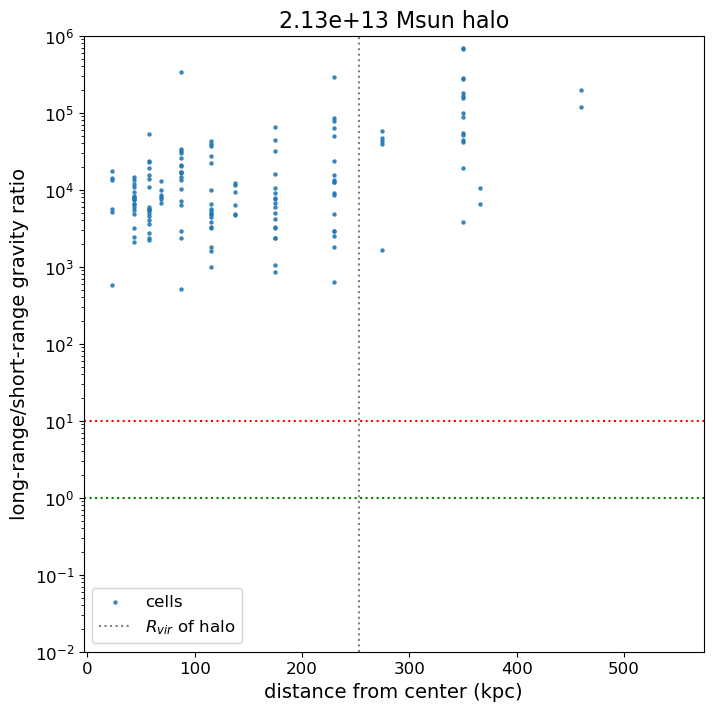

In [23]:
def sr_lr_comparison(
    cell_coords, sr_grid, lr_grid,
    Rvir, Mvir
    ):

    # Halo parameters.
    Rvir *= kpc
    Mvir *= 10**Mvir*Msun

    # Sort cells by distance from center (0,0,0).
    pos_grid = cell_coords/kpc
    grid_dist = np.sqrt(np.sum(pos_grid**2, axis=1))
    dist_order = grid_dist.argsort()
    grid_dist = grid_dist[dist_order]

    # Order short-range and long-range magnitudes.
    sr_mags = np.sqrt(np.sum(sr_grid**2, axis=1))
    lr_mags = np.sqrt(np.sum(lr_grid**2, axis=1))
    sr_mags = sr_mags[dist_order]
    lr_mags = lr_mags[dist_order]

    sr_mags[sr_mags == 0] = 1

    grav_ratio = lr_mags / sr_mags
    # grav_ratio = sr_mags / lr_mags
    print(f'min/max: {grav_ratio.min():.2e}/{grav_ratio.max():.2e}')

    fig, ax = plt.subplots(1,1)

    ax.set_title(f'{Mvir/Msun:.2e} Msun halo')
    ax.scatter(
        grid_dist, grav_ratio, s=5, alpha=0.8, 
        label=f'cells'
    )
    ax.axhline(1, c='green', ls=':')
    ax.axhline(10, c='red', ls=':')
    ax.axhline(np.min(grav_ratio), c='red', ls=':')
    ax.axvline(
        Rvir/kpc, c='black', ls=':', alpha=0.5, 
        label=r'$R_{vir}$ of halo'
    )

    ax.set_xlabel('distance from center (kpc)')
    ax.set_ylabel('long-range/short-range gravity ratio')

    ax.set_ylim(1e-2,1e6)
    ax.set_yscale('log')
    plt.legend()
    plt.show()


sr_lr_comparison(
    cell_coords, gravity_sr, gravity_lr,
    halo_rvir, halo_Mvir
)

## NFW comparison.

In [ ]:
def gravity_comparison_NFW(cell_coords, dPsi_grid, Rvir, Mvir, cNFW, z=0):

    # NFW parameters.
    Rvir *= kpc
    Mvir *= 10**Mvir*Msun
    Rs = Rvir/cNFW
    rho0 = fct.scale_density_NFW(z, cNFW)

    # Calculate NFW value at cell coords.
    NFW_cells = np.array([
        fct.dPsi_dxi_NFW(x_i, z, rho0, Mvir, Rvir, Rs, 'HALO')
        for x_i in cell_coords
    ])/(kpc/s**2)
    NFW_mags = np.sqrt(np.sum(NFW_cells**2, axis=1))

    # Magnitudes of gravity in each cell.
    dPsi_mags = np.sqrt(np.sum(dPsi_grid**2, axis=1))/(kpc/s**2)

    # Sort cells by distance from center (0,0,0).
    pos_grid = cell_coords/kpc
    grid_dist = np.sqrt(np.sum(pos_grid**2, axis=1))
    dist_order = grid_dist.argsort()

    grid_dist = grid_dist[dist_order]
    dPsi_mags = dPsi_mags[dist_order]
    NFW_mags = NFW_mags[dist_order]

    grav_ratio = dPsi_mags/NFW_mags
    print(f'dPsi/NFW: min={np.min(grav_ratio)}, max={np.max(grav_ratio)}')

    fig, ax = plt.subplots(1,1)

    ax.set_title(f'{Mvir/Msun:.2e} Msun halo')
    ax.scatter(
        grid_dist, grav_ratio, s=5, alpha=0.8, 
        label=f'cells'
    )
    ax.axhline(1, c='green', ls=':')
    ax.axhline(10, c='red', ls=':')
    ax.axhline(np.min(grav_ratio), c='red', ls=':')
    ax.axvline(
        Rvir/kpc, c='black', ls=':', alpha=0.5, 
        label=r'$R_{vir}$ of halo'
    )

    ax.set_xlabel('distance from center (kpc)')
    ax.set_ylabel('sim/NFW gravity ratio')

    ax.set_yscale('log')
    plt.legend()
    plt.show()

In [ ]:
gravity_comparison_NFW(
    cell_coords, gravity_sr, 
    halo_rvir, halo_Mvir, halo_cNFW, z=0
)


gravity_comparison_NFW(
    cell_coords, gravity_lr, 
    halo_rvir, halo_Mvir, halo_cNFW, z=0
)

gravity_comparison_NFW(
    cell_coords, gravity_sr+gravity_lr, 
    halo_rvir, halo_Mvir, halo_cNFW, z=0
)

## Directionality of gravity grid.

In [ ]:
def grid_arrows(
    cell_coords, dPsi_grid,
):

    # x,y,z of cell coordinates.
    pos_grid = cell_coords/kpc
    xGrid = pos_grid[:,0]
    yGrid = pos_grid[:,1]
    zGrid = pos_grid[:,2]

    # x,y,z of gravity grid.
    xPsi = dPsi_grid[:,0]
    yPsi = dPsi_grid[:,1]
    zPsi = dPsi_grid[:,2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # start, stop = 0, -1 
    start, stop = 250, -1 
    ax.quiver(
        xGrid[start:stop], yGrid[start:stop], zGrid[start:stop], 
        xPsi[start:stop], yPsi[start:stop], zPsi[start:stop], 
        length=10, normalize=True
    )

    plt.show()


grid_arrows(cell_coords, gravity_lr)